100%|██████████| 3638/3638 [00:21<00:00, 168.93it/s]


Train on 2720 samples, validate on 240 samples
Epoch 1/300
2720/2720 [==============================] - 9s 3ms/sample - loss: 10.1601 - mse: 10.1601 - val_loss: 0.0157 - val_mse: 0.0157

(0.0, 0.1)

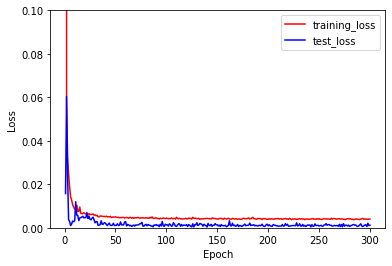

In [1]:
import cv2
import glob
import sys
import os
import numpy as np
import tqdm
from sklearn.model_selection import train_test_split
from tensorflow import keras
from functools import partial
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt


def load_file(path,x,y,x_1,y_1):
    files = glob.glob(path+'./*.jpg')
    if not files:
        print("Chck Phath")
        sys.exit()
    img = []
    for index, i in enumerate(tqdm.tqdm((files))):
        im = cv2.imread(i, cv2.IMREAD_GRAYSCALE)[y:y_1, x:x_1]
        if index == 0:
            ref_img = im
        img.append(np.stack([im, ref_img], axis = 2))
    return np.array(img)

features = load_file('../data/ML/', 211-50, 407-75,211+100,407+75)
target = np.array(pd.read_csv('../data/ML/target.csv', encoding='CP949'))[:,3]
min_max_scaler  = MinMaxScaler()
target = min_max_scaler.fit_transform(target.reshape(-1, 1))
target = savgol_filter(target.flatten(),201,1).reshape(-1, 1)

delete_index = [i for i in range(1,439)]
target = np.delete(target, delete_index, 0)
features = np.delete(features, delete_index, 0)

X_train,  X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.15, random_state=0)
X_train = X_train / 255.0
X_valid = X_valid / 255.0

X_valid,  X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=0)

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, input_shape=[150, 150, 2]),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=1),
])


model.compile(loss="mse", optimizer='RMSprop', metrics=["mse"])
history = model.fit(X_train, y_train, epochs=300, validation_data=(X_valid, y_valid))
score = model.evaluate(X_valid, y_valid)

training_loss = history.history["loss"]
test_loss = history.history["val_loss"]
epoch_count = range(1, len(training_loss)+1)


plt.plot(epoch_count, training_loss, "r-")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["training_loss", "test_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0,0.1)


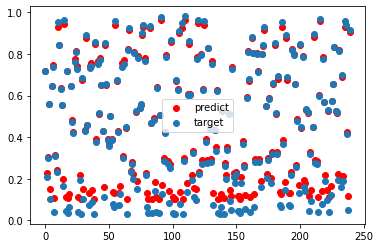

In [2]:
predicted_target = model.predict(X_test)

a = [i for i in range(240)]
plt.scatter(a, predicted_target,color='red',label='predict')
plt.scatter(a, y_test,label='target')

plt.legend()

0.9881413990863612

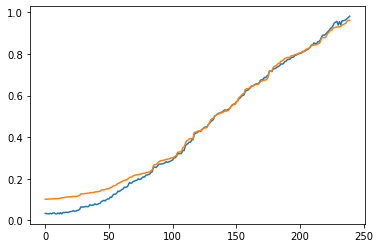

In [3]:
array = np.hstack((y_test.reshape(-1,1),predicted_target.reshape(-1,1)))
array = array[array[:,1].argsort()]

plt.plot(array[:,0])
plt.plot(array[:,1])

from sklearn.metrics import r2_score
r2_score(y_test, predicted_target)

In [4]:
model.save('ml.h5')


np.save('ml_training_loss',training_loss)
np.save('test_loss',test_loss)
